In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy import interpolate
from scipy.stats import norm

plt.style.use("classic")

## Constants & Libraries


In [2]:
def compute_forward_libor(
    delta_tenor: float,
    previous_discount_factor: float,
    current_discount_factor: float,
) -> float:
    return 1 / delta_tenor * (previous_discount_factor / current_discount_factor - 1)


def compute_forward_swap_rate(
    expiry: float,
    tenor: float,
    df_discount_factors: pd.DataFrame,
    floating_leg_period: float = 1,
    fixed_leg_period: float = 1,
) -> float:
    swap_end_time = expiry + tenor
    floating_leg_term = np.arange(
        expiry + floating_leg_period,
        swap_end_time + floating_leg_period,
        floating_leg_period,
    )
    fixed_leg_terms = np.arange(
        expiry + fixed_leg_period,
        swap_end_time + fixed_leg_period,
        fixed_leg_period,
    )
    floating_leg_pv = np.sum(
        floating_leg_period
        * df_discount_factors.loc[floating_leg_term, "Forward LIBOR"]
        * df_discount_factors.loc[floating_leg_term, "Discount Factor OIS"]
    )
    fixed_leg_pv = np.sum(
        fixed_leg_period
        * df_discount_factors.loc[fixed_leg_terms, "Discount Factor OIS"]
    )
    return floating_leg_pv / fixed_leg_pv

In [3]:
class AbstractBlack76Model:
    """
    A base class used to model Black-Scholes option model
    ...
    Parameters
    ----------
    F : float
        The forward price of the underlying asset
    K : float
        The strike price of the options
    discount_factor : float
        The "numeraire" discount factor of the model (i.e. PVBP, compounded discount factor)
    sigma : float
        Volatility
    T : float
        Maturity period (years)
    """

    def __init__(
        self,
        F: float,
        K: float,
        discount_factor: float,
        sigma: float,
        T: float,
    ):
        self.F = F
        self.K = K
        self.sigma = sigma
        self.T = T

        self.d1 = self._calculate_d1()
        self.d2 = self._calculate_d2()
        self.discount_factor = discount_factor

    def _calculate_d1(self) -> float:
        return (np.log(self.F / self.K) + self.sigma**2 / 2 * self.T) / (
            self.sigma * np.sqrt(self.T)
        )

    def _calculate_d2(self) -> float:
        return self.d1 - self.sigma * np.sqrt(self.T)


class VanillaBlack76Model(AbstractBlack76Model):
    def calculate_call_price(self) -> float:
        return self.discount_factor * (
            self.F * norm.cdf(self.d1) - self.K * norm.cdf(self.d2)
        )

    def calculate_put_price(self) -> float:
        return self.discount_factor * (
            -self.F * norm.cdf(-self.d1) + self.K * norm.cdf(-self.d2)
        )


class VanillaOption:
    def black_model(
        self, F: float, K: float, discount_factor: float, sigma: float, T: float
    ) -> VanillaBlack76Model:
        return VanillaBlack76Model(F, K, discount_factor, sigma, T)


def SABR_model(F, K, T, alpha, beta, rho, nu):
    K = np.min([K, 0.065])  # After 6.5% strike, cap it due to sabr explosion.
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta) ** 2) / 24) * alpha * alpha / (F ** (2 - 2 * beta))
        numer2 = 0.25 * rho * beta * nu * alpha / (F ** (1 - beta))
        numer3 = ((2 - 3 * rho * rho) / 24) * nu * nu
        VolAtm = alpha * (1 + (numer1 + numer2 + numer3) * T) / (F ** (1 - beta))
        sabrsigma = VolAtm
    else:
        z = (nu / alpha) * ((F * X) ** (0.5 * (1 - beta))) * np.log(F / X)
        zhi = np.log((((1 - 2 * rho * z + z * z) ** 0.5) + z - rho) / (1 - rho))
        numer1 = (((1 - beta) ** 2) / 24) * ((alpha * alpha) / ((F * X) ** (1 - beta)))
        numer2 = 0.25 * rho * beta * nu * alpha / ((F * X) ** ((1 - beta) / 2))
        numer3 = ((2 - 3 * rho * rho) / 24) * nu * nu
        numer = alpha * (1 + (numer1 + numer2 + numer3) * T) * z
        denom1 = ((1 - beta) ** 2 / 24) * (np.log(F / X)) ** 2
        denom2 = (((1 - beta) ** 4) / 1920) * ((np.log(F / X)) ** 4)
        denom = ((F * X) ** ((1 - beta) / 2)) * (1 + denom1 + denom2) * zhi
        sabrsigma = numer / denom
    return sabrsigma

## Data Import


In [4]:
df_discount_factors = pd.read_csv(
    "../bootstrap_swap_curve/output/part_1_bootstrapped_discount_factors.csv",
    index_col=0,
)

In [5]:
df_swap_rates = pd.read_csv(
    "../swaption_calibration/output/part_2_swap_rates.csv", index_col=0
)

In [6]:
df_sabr_params = pd.read_csv(
    "../swaption_calibration/output/part_2_sabr_params.csv", index_col=0
)
df_sabr_alpha = df_sabr_params.pivot(index="expiry", columns="tenor", values="alpha")
df_sabr_beta = df_sabr_params.pivot(index="expiry", columns="tenor", values="beta")
df_sabr_rho = df_sabr_params.pivot(index="expiry", columns="tenor", values="rho")
df_sabr_nu = df_sabr_params.pivot(index="expiry", columns="tenor", values="nu")

## Format and Manipulate Data


In [7]:
def format_discount_factors_data(df_discount_factors: pd.DataFrame) -> pd.DataFrame:
    # Insert Tenor = 0 data
    df_discount_factors.loc[0] = [np.nan, 0, 0, 1, 0, 1]
    df_discount_factors.sort_index(inplace=True)

    # Make data more granular and interpolate discount factors
    min_tenor = df_discount_factors.index.min()
    max_tenor = df_discount_factors.index.max()
    delta_tenor = 0.25
    df_discount_factors = df_discount_factors.reindex(
        df_discount_factors.index.union(np.arange(min_tenor, max_tenor, delta_tenor))
    )
    df_discount_factors["Discount Factor LIBOR"] = df_discount_factors[
        "Discount Factor LIBOR"
    ].interpolate(method="linear")
    df_discount_factors["Discount Factor OIS"] = df_discount_factors[
        "Discount Factor OIS"
    ].interpolate(method="linear")

    # Compute missing Forward LIBOR data
    prev_index = 0.5
    for index, row in df_discount_factors.iterrows():
        discount_factor_libor, forward_libor = (
            row["Discount Factor LIBOR"],
            row["Forward LIBOR"],
        )
        if np.isnan(forward_libor):
            prev_discount_factor_libor = df_discount_factors.loc[
                prev_index, "Discount Factor LIBOR"
            ]
            interpolated_forward = compute_forward_libor(
                delta_tenor, prev_discount_factor_libor, discount_factor_libor
            )
            df_discount_factors.loc[index, "Forward LIBOR"] = interpolated_forward
        prev_index = index
    return df_discount_factors.copy()


df_discount_factors = format_discount_factors_data(df_discount_factors)

## Pre-computation


In [8]:
vanilla_option = VanillaOption()

sabr_alpha_interp = interpolate.interp2d(
    df_sabr_alpha.index, df_sabr_alpha.columns, df_sabr_alpha.values.T, kind="linear"
)
sabr_beta_interp = interpolate.interp2d(
    df_sabr_beta.index, df_sabr_beta.columns, df_sabr_beta.values.T, kind="linear"
)
sabr_rho_interp = interpolate.interp2d(
    df_sabr_rho.index, df_sabr_rho.columns, df_sabr_rho.values.T, kind="linear"
)
sabr_nu_interp = interpolate.interp2d(
    df_sabr_nu.index, df_sabr_nu.columns, df_sabr_nu.values.T, kind="linear"
)

## 1. CMS PV Calculation


In [9]:
def IRR_0(K: float, m: float, N: float) -> float:
    return 1 / K * (1 - 1 / (1 + K / m) ** (m * N))


def IRR_1(K: float, m: float, N: float) -> float:
    return -1 / K * IRR_0(K, m, N) + 1 / (K * m) * N * m / (1 + K / m) ** (N * m + 1)


def IRR_2(K: float, m: float, N: float) -> float:
    return -2 / K * IRR_1(K, m, N) - 1 / (K * m * m) * (N * m) * (N * m + 1) / (
        1 + K / m
    ) ** (N * m + 2)


def g_0(K: float) -> float:
    return K


def g_1(K: float) -> float:
    return 1.0


def g_2(K: float) -> float:
    return 0.0


def h_1(K: float, m: float, N: float) -> float:
    return (IRR_0(K, m, N) * g_1(K) - g_0(K) * IRR_1(K, m, N)) / IRR_0(K, m, N) ** 2


def h_2(K: float, m: float, N: float) -> float:
    return (
        IRR_0(K, m, N) * g_2(K)
        - IRR_2(K, m, N) * g_0(K)
        - 2.0 * IRR_1(K, m, N) * g_1(K)
    ) / IRR_0(K, m, N) ** 2 + 2.0 * IRR_1(K, m, N) ** 2 * g_0(K) / IRR_0(K, m, N) ** 3


def irr_settled_option_price(
    discount_factor: float,
    F: float,
    K: float,
    sigma: float,
    T: float,
    m: float,
    N: float,
    swaption_type: str,
) -> float:
    irr_0 = IRR_0(F, m, N)
    discount_factor_numeraire = 1  # 1 / irr_0
    black_model = vanilla_option.black_model(F, K, discount_factor_numeraire, sigma, T)
    if swaption_type == "receiver":
        price = black_model.calculate_put_price()
    else:
        price = black_model.calculate_call_price()
    return discount_factor * irr_0 * price


def compute_cms_rate(
    expiry: float,
    tenor: float,
    payment_period: float,
    discount_factor: float,
    df_discount_factors: pd.DataFrame,
) -> float:
    F = compute_forward_swap_rate(
        expiry, tenor, df_discount_factors, payment_period, payment_period
    )
    alpha = sabr_alpha_interp(expiry, tenor)[0]
    beta = sabr_beta_interp(expiry, tenor)[0]
    rho = sabr_rho_interp(expiry, tenor)[0]
    nu = sabr_nu_interp(expiry, tenor)[0]

    first_term = g_0(F)
    second_term = quad(
        lambda x: h_2(x, 1 / payment_period, tenor)
        * irr_settled_option_price(
            discount_factor,
            F,
            x,
            SABR_model(F, x, expiry, alpha, beta, rho, nu),
            expiry,
            1 / payment_period,
            tenor,
            "receiver",
        ),
        0,
        F,
    )[0]

    third_term = quad(
        lambda x: h_2(x, 1 / payment_period, tenor)
        * irr_settled_option_price(
            discount_factor,
            F,
            x,
            SABR_model(F, x, expiry, alpha, beta, rho, nu),
            expiry,
            1 / payment_period,
            tenor,
            "payer",
        ),
        F,
        float("inf"),
    )[0]

    return first_term + (second_term + third_term) / discount_factor


def compute_pv_cms(
    swap_rates_period: float,
    payment_period: float,
    tenor: float,
    df_discount_factors: pd.DataFrame,
):
    payment_terms = np.arange(payment_period, tenor + payment_period, payment_period)
    pv_cms = []
    for term in payment_terms:
        discount_factor = df_discount_factors.loc[term, "Discount Factor OIS"]
        cashflow_at_term = (
            discount_factor
            * payment_period
            * compute_cms_rate(
                term,
                swap_rates_period,
                payment_period,
                discount_factor,
                df_discount_factors,
            )
        )
        pv_cms.append(cashflow_at_term)

    return np.sum(pv_cms)

In [10]:
def h_2(K: float, m: float, N: float) -> float:
    return (
        IRR_0(K, m, N) * g_2(K)
        - IRR_2(K, m, N) * g_0(K)
        - 2.0 * IRR_1(K, m, N) * g_1(K)
    ) / IRR_0(K, m, N) ** 2 + 2.0 * IRR_1(K, m, N) ** 2 * g_0(K) / IRR_0(K, m, N) ** 3

In [11]:
CMS_PV = [
    # {
    #     "name": "CMS10y semi-annual over the next 2 years",
    #     "swap_rate_period": 10,
    #     "payment_period": 0.5,
    #     "tenor": 2,
    # },
    {
        "name": "CMS10y semi-annually over the next 5 years",
        "swap_rate_period": 10,
        "payment_period": 0.5,
        "tenor": 5,
    },
    {
        "name": "CMS2y quarterly over the next 10 years",
        "swap_rate_period": 2,
        "payment_period": 0.25,
        "tenor": 10,
    },
]

In [12]:
for cms in CMS_PV:
    name, swap_rate_period, payment_period, tenor = (
        cms["name"],
        cms["swap_rate_period"],
        cms["payment_period"],
        cms["tenor"],
    )
    pv = compute_pv_cms(swap_rate_period, payment_period, tenor, df_discount_factors)
    print("PV of {} = {}".format(name, pv))

PV of CMS10y semi-annually over the next 5 years = 0.210127639490055
PV of CMS2y quarterly over the next 10 years = 0.38905400918768307


## 2. CMS Rate Calculation


In [13]:
cms_start_time = [1, 5, 10]
cms_duration = [1, 2, 3, 5, 10]
forward_swaps = [[x, y] for x in cms_start_time for y in cms_duration]

In [14]:
cms_rates = []
for forward_swap in forward_swaps:
    expiry, tenor = forward_swap
    discount_factor = df_discount_factors.loc[tenor, "Discount Factor OIS"]
    swap_rate = compute_cms_rate(
        expiry,
        tenor,
        0.5,
        discount_factor,
        df_discount_factors,
    )
    cms_rates.append([expiry, tenor, swap_rate])

df_cms_rates = pd.DataFrame(
    cms_rates,
    columns=[
        "Expiry",
        "Tenor",
        "CMS Rate",
    ],
)

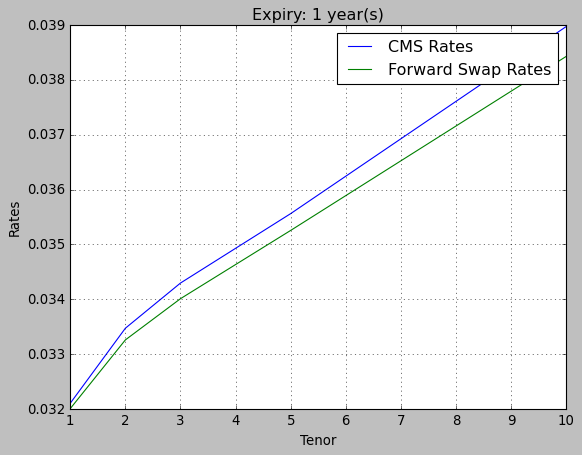

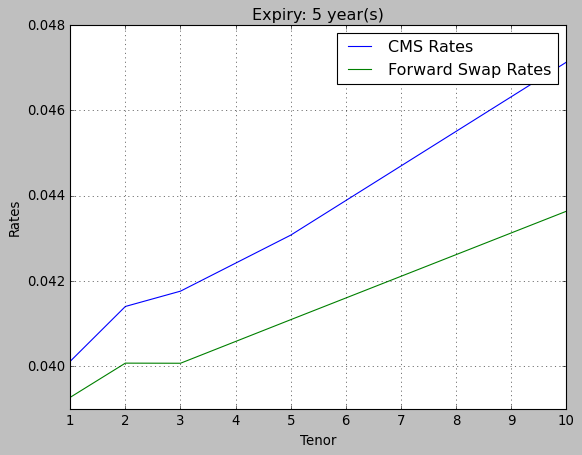

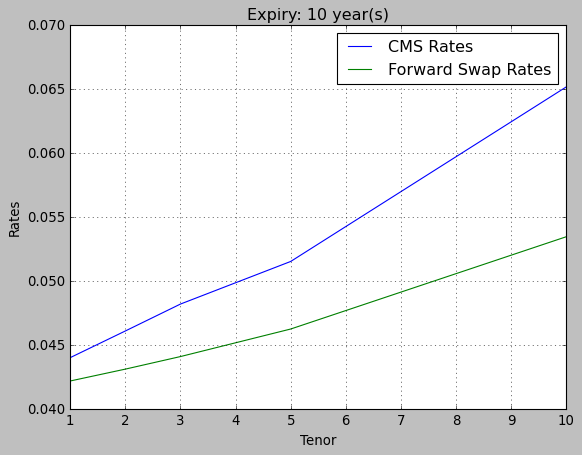

In [15]:
for expiry in np.unique(df_cms_rates["Expiry"].values):
    df_cms_rates_tmp = df_cms_rates[df_cms_rates["Expiry"] == expiry]
    df_swap_rates_tmp = df_swap_rates[df_swap_rates["Expiry"] == expiry]

    plt.title("Expiry: {} year(s)".format(expiry))
    plt.plot(df_cms_rates_tmp["Tenor"], df_cms_rates_tmp["CMS Rate"], label="CMS Rates")
    plt.plot(
        df_swap_rates_tmp["Tenor"],
        df_swap_rates_tmp["Swap Rate"],
        label="Forward Swap Rates",
    )
    plt.xlabel("Tenor")
    plt.ylabel("Rates")
    plt.legend()
    plt.grid()
    plt.show()